<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Advanced Analytics (QBUS3830)</h1>
<h2 align="center" style="margin-top:10px">Homework Task 4: Additive Models</h2>
<br>

Setting up the notebook for figures:

In [11]:
# Packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colors = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colors)
plt.rcParams['figure.figsize'] = (9, 6)

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb

## California housing dataset

### Data processing

In [1]:
from sklearn.datasets import fetch_california_housing
raw = fetch_california_housing()
print(raw.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




In [4]:
data = pd.DataFrame(raw.data, columns=raw.feature_names)
data['MedianHouseValue']=raw.target
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Some of the predictors have severe outliers, which we delete for simplicity. 

In [5]:
data=data[data['AveRooms']<data['AveRooms'].quantile(.99)]
data=data[data['Population']<data['Population'].quantile(.99)]
data=data[data['AveOccup']<data['AveOccup'].quantile(.99)]

### Train-test split

In [8]:
response = data.columns[-1]
predictors= list(data.columns[:-1])

index_train, index_test  = train_test_split(np.array(data.index), train_size=0.2, random_state=1)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

# Write training and test response vectors
y_train = np.log(train[response])
y_test = np.log(test[response])

# Write training and test design matrices
X_train = train[predictors].copy()
X_test = test[predictors].copy()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Exploratory Data Analysis

The next cell plots a map of house prices. It takes about a minute to run

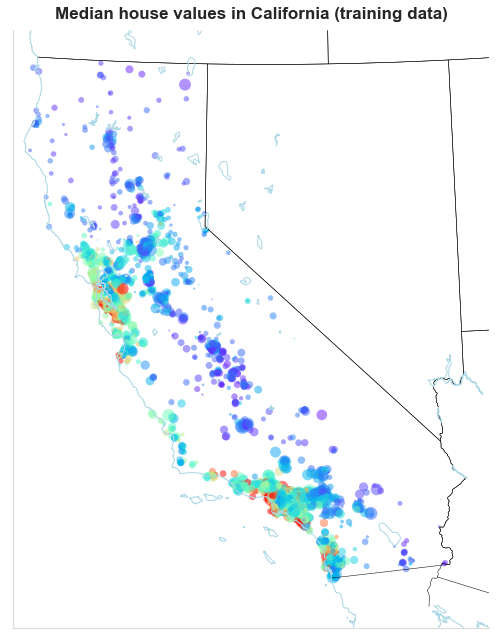

In [12]:
from mpl_toolkits.basemap import Basemap

def california_map(ax=None, lllat=31.5, urlat=42.5,
                   lllon=-124,urlon=-113):
# This function is from "Data Analytics Using Open-Source Tools" by Jeffrey Strickland
    
    m = Basemap(ax=ax, projection='stere',
                lon_0=(urlon + lllon) / 2,
                lat_0=(urlat + lllat) / 2,
                llcrnrlat=lllat, urcrnrlat=urlat,
                llcrnrlon=lllon, urcrnrlon=urlon, resolution='f')
    m.drawstates()
    m.drawcountries()
    m.drawcoastlines(color='lightblue')
    return m


fig, ax = plt.subplots(figsize=(9,9))
m = california_map()
x, y = m(train['Longitude'].as_matrix(), train['Latitude'].as_matrix())

cmap = sns.diverging_palette(220, 10, as_cmap=True)
m.scatter(x,y,s=train['Population']/30, c=train['MedianHouseValue'], edgecolors='none', cmap=plt.get_cmap('rainbow'),
         alpha=0.5)

ax.set_title('Median house values in California (training data)', fontsize=17, y=1.01, fontweight='bold')
ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['top'].set_color('#DDDDDD')
ax.spines['right'].set_color('#DDDDDD')
ax.spines['left'].set_color('#DDDDDD')

plt.tight_layout()
plt.show()

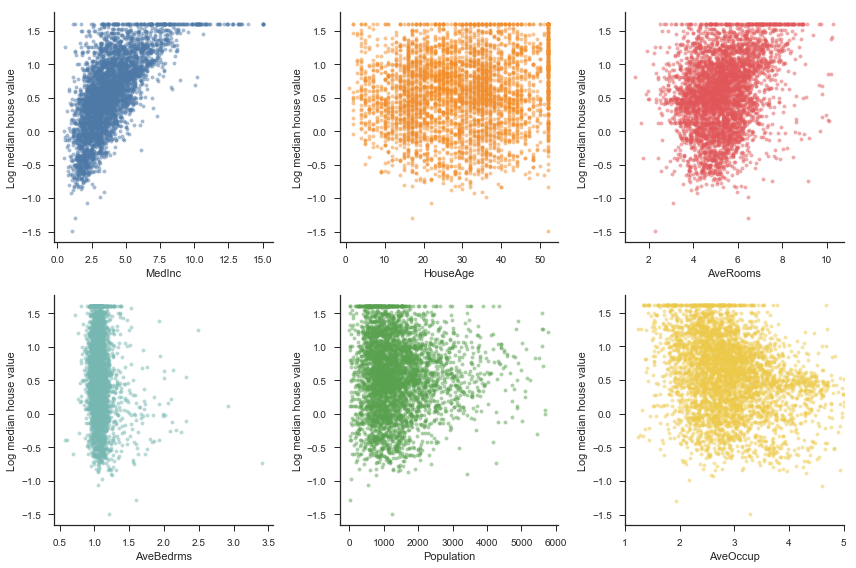

In [17]:
fig, axes = plt.subplots(2,3, figsize=(12,8))

for i, ax in enumerate(fig.axes):
    sns.regplot(X_train.iloc[:,i], y_train, scatter_kws = {'s': 15, 'alpha': 0.5}, ax=ax, fit_reg=False)
    ax.set_ylabel('Log median house value')
ax.set_xlim(1,5)
    
sns.despine()
plt.tight_layout()
plt.show()

## Models

### Linear regression

In [19]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Gradient boosting: LightGBM

In [21]:
%%time

model = lgb.LGBMRegressor(objective='regression')

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4, 
                               random_state = 20)

gb_search.fit(X_train, y_train)

lbst = gb_search.best_estimator_


print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.6, 'n_estimators': 2000, 'max_depth': 4, 'learning_rate': 0.05} 

Wall time: 1min 27s


### Gradient boosting: XGBoost

In [22]:
%%time

model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500, 2000, 3000, 5000],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4,
                              random_state = 20)
gb_search.fit(X_train, y_train)

xbst = gb_search.best_estimator_


print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.1} 

Wall time: 3min 16s


### Model evaluation

In [24]:
columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['OLS', 'LightGBM', 'XGBoost']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, lbst, xbst]

for i, method in enumerate(methods):
    
    y_pred=method.predict(X_test)
    
    # Truncating implausible predictions, just in case
    y_pred[y_pred>1.609]=1.609
    y_pred[y_pred<-2]=-2

        
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2,Test MAE
OLS,0.318,0.691,0.239
LightGBM,0.235,0.831,0.163
XGBoost,0.236,0.830,0.165
